In [1]:
from astropy.io import fits

In [2]:
tile_loc = '/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline_runs/remote_debug/tiles/EUC_MER_BGSUB-MOSAIC-VIS_TILE102021539-F91316_20240405T233444.877933Z_00.00.fits'

In [3]:
fits.open(tile_loc)

In [4]:
fits.getdata(tile_loc)

array([[ 0.00217012, -0.00298822, -0.00266482, ...,  0.00205332,
         0.00237424,  0.00053189],
       [ 0.00096305,  0.00064872,  0.00019174, ...,  0.00042276,
         0.00543503,  0.00245586],
       [ 0.00092425,  0.00276194, -0.00041444, ...,  0.00192536,
         0.01117192,  0.00637266],
       ...,
       [-0.00067974,  0.00013628,  0.0004127 , ...,  0.00527447,
         0.00363898, -0.00170511],
       [-0.00229512, -0.00093901,  0.00036935, ...,  0.00340656,
         0.000568  , -0.00067064],
       [ 0.00084896,  0.00160399, -0.00228888, ...,  0.00074724,
        -0.00152757,  0.00242576]], dtype=float32)

In [5]:
# No other data, so no PSF here

# PSF was originally under this data product
# DpdMerBksMosaic
# https://euclid.roe.ac.uk/issues/22495
# but in SAS it is not

# manually poking around, it is actually under sedm.aux_mosaic

In [6]:
from astroquery.esa.euclid.core import Euclid
# two line file, username and password
# do not commit or put in any team workspace, obviously...
Euclid.login(credentials_file='/media/user/_credentials/euclid_login.txt')

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


In [7]:
    query_str = f"""
        SELECT * FROM sedm.aux_mosaic 
        WHERE (product_type_sas='MERPSF')
        AND (mosaic_product_oid=1438)
        """
    job = Euclid.launch_job_async(query_str, verbose=False, background=False) 
    assert job is not None, 'Query failed with: \n' + query_str
    df_psf = job.get_results().to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


In [8]:
df_psf

,aux_mosaic_oid,checksum,file_name,file_path,mosaic_product_oid,product_type_sas,stype,to_be_published
0,6420,10b516a87defac5e0acba2a97617974c,EUC_MER_CATALOG-PSF-VIS_TILE101159484-B0797F_2...,/data_03/repository_otf/MER/101159484/VIS,1438,MERPSF,PSF,1


In [9]:
    query_str = f"""
        SELECT * FROM sedm.mosaic_product 
        WHERE (mosaic_product_oid=1438)
        """
    job = Euclid.launch_job_async(query_str, verbose=False, background=False) 
    assert job is not None, 'Query failed with: \n' + query_str
    df_tile = job.get_results().to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


In [10]:
df_tile

,category,checksum,creation_date,crpix1,crpix2,crval1,crval2,data_release_oid,data_size,dec,...,ra,release_date,release_name,second_type,stc_s,technique,tile_index,to_be_published,zero_point,zero_point_error
0,SCIENCE,aff9f976cc1ba4b0975871a0245b8a60,2024-01-14T01:53:17.263,9600.0,9600.0,266.757377,66.5,6,-32.0,66.5,...,266.757377,<NA>,CALBLOCK_PV-005_R3,SKY,Polygon J2000 267.4189548598171 66.23195419911...,IMAGE,101159484,1,24.4,0.1


In [11]:
Euclid.get_product(file_name=df_psf['file_name'].squeeze(), output_file='temp_psf.fits')[0]

Retrieving data.
Data request: TAPCLIENT=ASTROQUERY&RELEASE=sedm&FILE_NAME=EUC_MER_CATALOG-PSF-VIS_TILE101159484-B0797F_20240113T083926.969140Z_00.00.fits&RETRIEVAL_TYPE=FILE
------>https
host = easotf.esac.esa.int:443
context = /sas-dd/data
Content-type = application/x-www-form-urlencoded
200 
Reading...
Done.


'temp_psf.fits'

In [15]:
psf_data = fits.open('/media/home/my_workspace/repos/bulk-euclid-cutouts/tests/temp_psf.fits')


In [16]:
psf_data[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 7258                                                  
NAXIS2  =                 7258                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EQUINOX =        2000.00000000 / Mean equinox                                   
RADESYS = 'ICRS    '           / Astrometric system                             
CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              
CUNIT1  = 'deg     '           / Axis unit                                      
CRVAL1  =   2.667573769098E+02 / World coordinate on this axis                  
CRPIX1  =                 96

In [17]:
stamp_size = psf_data[1].header['STMPSIZE']
stamp_size

19

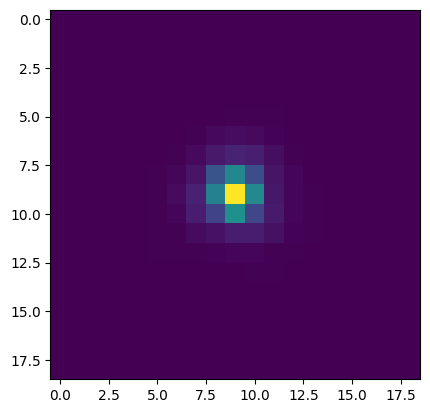

In [18]:
import matplotlib.pyplot as plt


psf_data[1].data.shape

# - an image with PSF cutouts of selected objects arranged next to each other. The stamp pixel size can be found in the header keyword STMPSIZE (e.g. 19 for VIS, 33 for NIR).
plt.imshow(psf_data[1].data[stamp_size*3:stamp_size*4, stamp_size*3:stamp_size*4])  # first of many

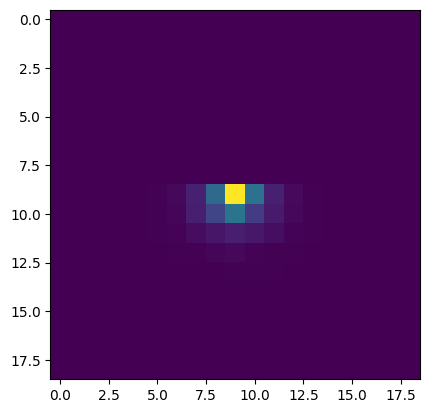

In [20]:
plt.imshow(psf_data[1].data[:stamp_size, :stamp_size])  # first of many

In [19]:
from astropy.table import Table

# - a table giving the match between the PSF cutout center position (columns x_center and y_center) on the PSF grid image and the coordinate in pixels (columns x and y) or on the sky (Ra, Dec) on the MER tile data.
Table.read(psf_data[2])

x_center,y_center,x,y,RA,Dec,FWHM
float64,float64,float64,float64,float64,float64,float64
10.0,10.0,10957.0,1.0,266.66384629397515,66.23333487891352,0.15000386847581637
29.0,10.0,16898.0,1.0,266.2543780117045,66.23254866078325,0.16688382446148647
48.0,10.0,5110.0,1.0,267.06684540961635,66.23305477652738,0.16444399162903878
67.0,10.0,11161.0,1.0,266.64978571644735,66.23332577679547,0.15433082303640008
86.0,10.0,882.0,1.0,267.3582396517485,66.23220092979258,0.16648614788676352
105.0,10.0,2150.0,1.0,267.27085152462195,66.23251438542701,0.16924574094399233
124.0,10.0,5956.0,1.0,267.00853658831477,66.23315999584239,0.1622016526862737
143.0,10.0,7027.0,1.0,266.9347193709385,66.23326180669997,0.15702495949149176
162.0,10.0,6830.0,146.0,266.9483279239938,66.23727338166304,0.20545268807253203


In [ ]:
# from sklearn.neighbors import KDTree

In [18]:
grid_psf_loc = 'EUC_MER_GRID-PSF-VIS_TILE101159484-88FF12_20240112T223553.693625Z_00.00.fits'
Euclid.get_product(file_name=grid_psf_loc, output_file='temp_grid_psf.fits')[0]

Retrieving data.
Data request: TAPCLIENT=ASTROQUERY&RELEASE=sedm&FILE_NAME=EUC_MER_GRID-PSF-VIS_TILE101159484-88FF12_20240112T223553.693625Z_00.00.fits&RETRIEVAL_TYPE=FILE
------>https
host = easotf.esac.esa.int:443
context = /sas-dd/data
Content-type = application/x-www-form-urlencoded
200 
Reading...
Done.


'temp_grid_psf.fits'

In [19]:
grid_psf = fits.open('temp_grid_psf.fits')

In [20]:
grid_psf[1].data.shape

(19200, 19200)

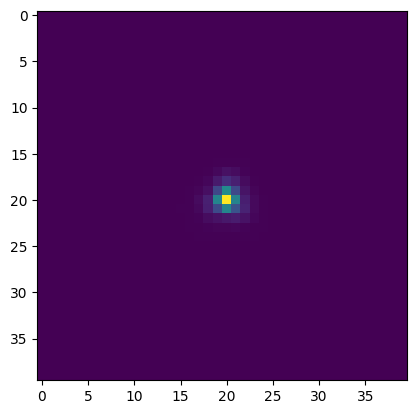

In [21]:
plt.imshow(grid_psf[1].data[40:80, 40:80])

In [22]:
from astropy.table import Table

# - a table giving the match between the PSF cutout center position (columns x_center and y_center) on the PSF grid image and the coordinate in pixels (columns x and y) or on the sky (Ra, Dec) on the MER tile data.
Table.read(grid_psf[2])

x,y,FWHM
float64,float64,float64
61.0,61.0,0.20323053483078765
61.0,181.0,0.19668212489402
61.0,301.0,0.21544412354195713
61.0,421.0,0.20648502188808124
61.0,541.0,0.20496775479335524
61.0,661.0,0.21033831387592153
61.0,781.0,0.20819955789418243
61.0,901.0,0.2006635661498068
61.0,1021.0,0.20396432294693714


In [23]:
# find closest match between target and PSF catalog (ignoring edges?)
# get center of that closest PSF
# slice out the PSF with stamp size, save

In [24]:
# !pip install scikit-learn

In [24]:
import numpy as np

In [81]:
# check my download

# hdu = fits.open('/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline_runs/external_targets_debug/cutouts/fits/102021539/a.fits')
hdu = fits.open('/media/home/my_workspace/repos/bulk-euclid-cutouts/tests/test_saving_cutouts/fits/102021539/a.fits')

hdu

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f531c5aafa0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c55eb20>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c5590d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c559250>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c559490>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c5596d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c559910>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c55edc0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c55ec40>]

In [82]:
hdu[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  200                                                  
NAXIS2  =                  200                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               7958.0 / Pixel coordinate of reference point            
CRPIX2  =              -3955.0 / Pixel coordinate of reference point            
PC1_1   =  -2.777777777778E-05 / Coordinate transformation matrix element       
PC2_2   =   2.777777777778E-05 / Coordinate transformation matrix element       
CDELT1  =                  1

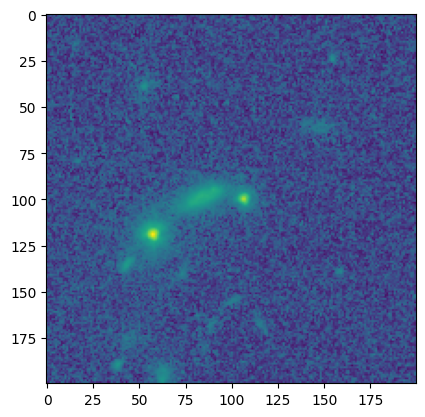

In [83]:
plt.imshow(np.arcsinh(500*hdu[1].data))  # vis image

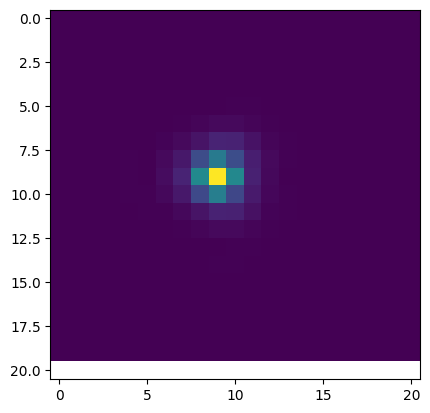

In [84]:
plt.imshow(hdu[2].data)  # vis psf

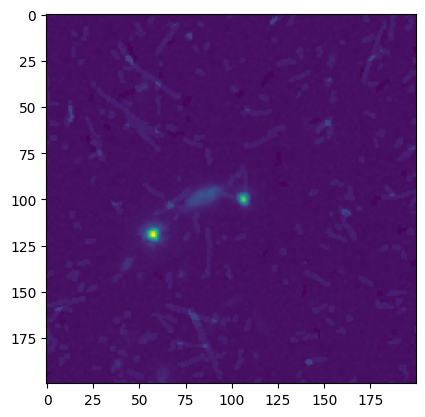

In [85]:
plt.imshow(np.arcsinh(500*hdu[3].data))  # vis rms

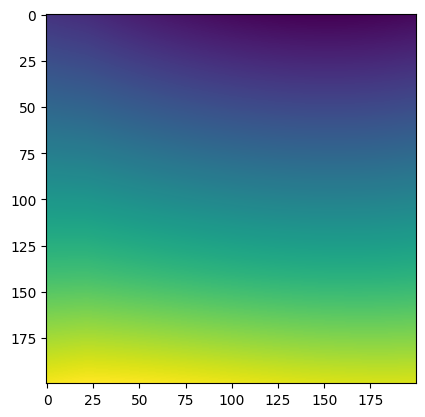

In [86]:
plt.imshow(hdu[4].data)  # vis bkg

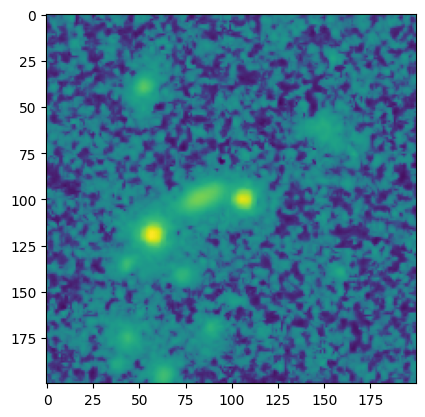

In [87]:
plt.imshow(np.arcsinh(10*hdu[5].data))  # nir y flux

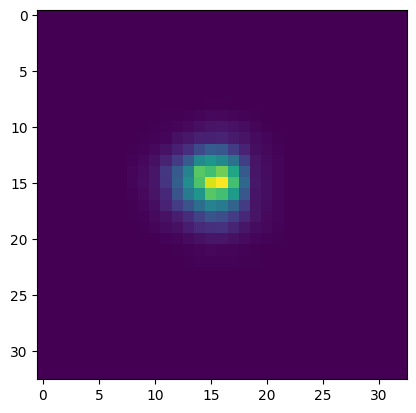

In [88]:
plt.imshow(hdu[6].data)  # nir y psf

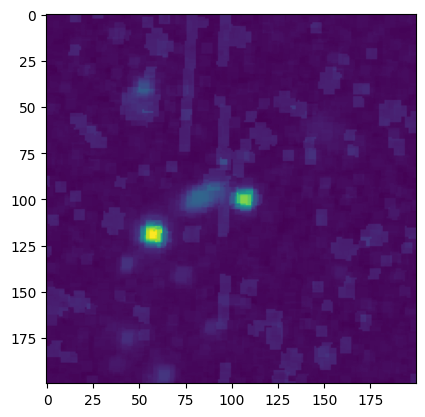

In [89]:
plt.imshow(np.arcsinh(500*hdu[7].data))  # nir y rms

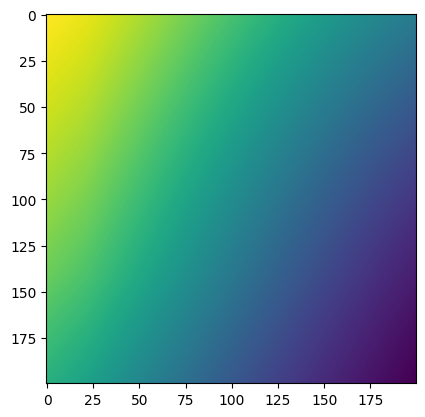

In [90]:
plt.imshow(np.arcsinh(500*hdu[8].data))  # nir y bkg